# Exploring the data: Part 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import glob
import random
%matplotlib inline

In [2]:
station=pd.read_csv('data/metadata.csv')
files=[i for i in glob.glob('data/station*')]

### Merge station & country data
We import data from all stations and format it: converting timestamps into datetime objects, splitting the flavor column, and adding corresponding station and country columns.

In [3]:
#import and combine data from all stations into a dataframe, add a column with station number
combined=pd.concat([pd.read_csv(f).assign(statn=f[-7:-4]) for f in files],ignore_index=True)
combined['statn']=combined['statn'].astype(int)

#Convert timestamp to datetime object, round to drop sec/milisec
combined.timestamp=pd.to_datetime(combined.timestamp)
combined['timestamp'] = combined.timestamp.dt.round(freq='min') 
combined.tail()

,amount_vended_L,flavor_id,flavor_levels_after,flavor_name,tank_level_after,timestamp,statn
736906,0.5,19,"413,255,500",cucumber,2.5,2019-05-30 13:46:00,49
736907,1.0,19,"413,254,500",cucumber,1.5,2019-05-30 13:52:00,49
736908,0.5,-1,"413,254,500",water,1.0,2019-05-30 13:57:00,49
736909,1.0,-1,"413,254,500",water,0.0,2019-05-30 14:03:00,49
736910,0.5,19,"413,253,500",cucumber,499.5,2019-06-01 02:53:00,49


In [4]:
#Split flavor_levels_after into 3 separate columns based on comma separator
temp = [combined.flavor_levels_after[i].split(',') for i in range(len(combined))]
combined['F1'],combined['F2'],combined['F3']  = zip(*[(int(i[0]),int(i[1]),int(i[2])) for i in temp])
combined.drop(columns='flavor_levels_after',inplace=True)

In [5]:
#Add country column from metadata, to group and gain country insights later
country_dict = station.set_index('id').to_dict()['country']
combined['country']=[country_dict[i] for i in combined.statn]
combined.sort_values(by=['country','statn','timestamp'],inplace=True)
combined.tail()

,amount_vended_L,flavor_id,flavor_name,tank_level_after,timestamp,statn,F1,F2,F3,country
648162,1.0,9,acai,510.0,2019-05-30 21:29:00,43,484,436,497,UTO
648163,0.5,9,acai,509.5,2019-05-30 21:57:00,43,484,435,497,UTO
648164,1.0,-1,water,508.5,2019-05-30 22:24:00,43,484,435,497,UTO
648165,1.0,9,acai,507.5,2019-05-30 23:11:00,43,484,434,497,UTO
648166,1.0,9,acai,506.5,2019-05-31 00:32:00,43,484,433,497,UTO


### Understanding the data
There are 3 flavors at any station at any time, and we have parsed the flavor_levels column into one for each dispenser. But the flavors in the dispensers get changed over time. Often, when a flavor gets over, it is replaced with a new flavor. Sometimes it might be replaced by the same one. The analysis we do in this section will give us more insights. 

It is also surprising that flavor level goes down by 1 for both 0.5 and 1L, and that we don't see indications of 'mix and match' of flavors.


Plain water is 17.2% of drink volume vended


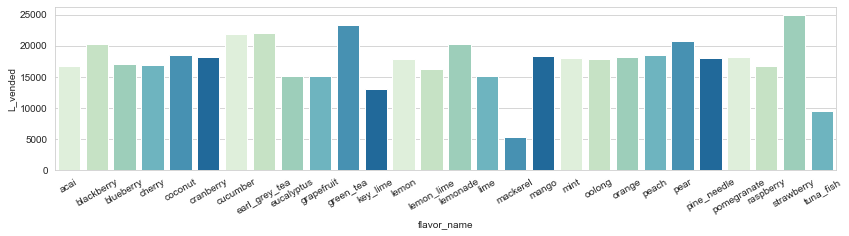

In [6]:
#Get an idea of freq of flavor choice. 
L_flavor=combined.groupby(['flavor_name'],).amount_vended_L.sum().to_frame('L_vended').reset_index()
L_flavor.columns=['flavor_name','L_vended']
print('Plain water is ' +str(round(100*int(L_flavor[L_flavor.flavor_name=='water'].L_vended.values)/L_flavor.L_vended.sum(),1))+'% of drink volume vended')
#Remove water because it overshadowed individual flavores
L_flavor=L_flavor[L_flavor.flavor_name!='water']

plt.figure(figsize=(14, 3))
sns.set_style("whitegrid")
ax=sns.barplot(y="L_vended", x="flavor_name", palette=sns.color_palette('GnBu'), data=L_flavor)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [7]:
#Find all flavors offered at each station
flavs_at_stns=combined.groupby('statn').flavor_name.unique()
n=random.randrange(50)
print(f'Flavors in first half of 2019 at station {n} are: '+str(flavs_at_stns[n]))

Flavors in first half of 2019 at station 39 are: ['grapefruit' 'mango' 'key_lime' 'water' 'oolong' 'green_tea'
 'earl_grey_tea' 'blackberry' 'raspberry' 'pomegranate' 'lemon_lime'
 'mint' 'lemonade' 'acai' 'blueberry' 'tuna_fish' 'cranberry' 'peach'
 'strawberry' 'eucalyptus' 'pine_needle' 'mackerel' 'pear']


A lot of different flavors were offered at most stations. The matrix we'll create to find correlation and do recommendation might not be so sparce.

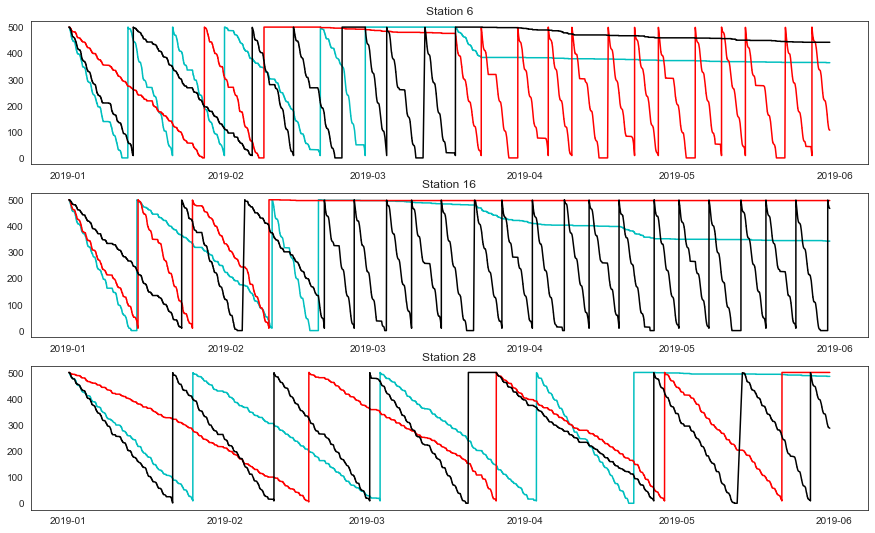

In [8]:
stn_flavor_plot=[6,16,28] #range(50) #To see all
n=len(stn_flavor_plot)
sns.set_style("white")
fig, ax = plt.subplots(n,1, figsize=(15, 3*n))
for i in range(n):
    df=combined[combined['statn']==stn_flavor_plot[i]]
    ax[i].plot_date(df.timestamp,df.F1,fmt='c-')
    ax[i].plot_date(df.timestamp,df.F2,fmt='r-')
    ax[i].plot_date(df.timestamp,df.F3,fmt='k-')
    ax[i].title.set_text('Station '+str(stn_flavor_plot[i]))

It seems that unpopular flavors (ones that aren't chosed & take a long time to get vended/consumed) aren't replaced for a long time. If the objective is for people to consume more of this healthy drink, unpopular flavors can be replaced sooner. 
More on this in Flavor Preference analysis in Flavor_modeling.ipynb.

### Variatiability
We explore:
- Are more drinks consumed on weekends?
- Do we see a summer/winter pattern? (assuming hot summer > increased seltzer demand)
- Is there a lot of variability in consumption day to day, or do we have predicatable demand and a regular customer base

In [9]:
combined['month']=combined.timestamp.dt.month
combined['weekday']=combined.timestamp.dt.weekday
combined['hour']=combined.timestamp.dt.hour
combined['date']=combined.timestamp.dt.date
#combined.tail()

In [10]:
#Daily consumption at differemt stations #To do:order and color by country
L_day=combined.groupby(['statn','date']).amount_vended_L.sum().reset_index(name ='total_consumed')
L_day.head()

,statn,date,total_consumed
0,0,2019-01-01,83.5
1,0,2019-01-02,85.5
2,0,2019-01-03,82.0
3,0,2019-01-04,78.5
4,0,2019-01-05,86.0


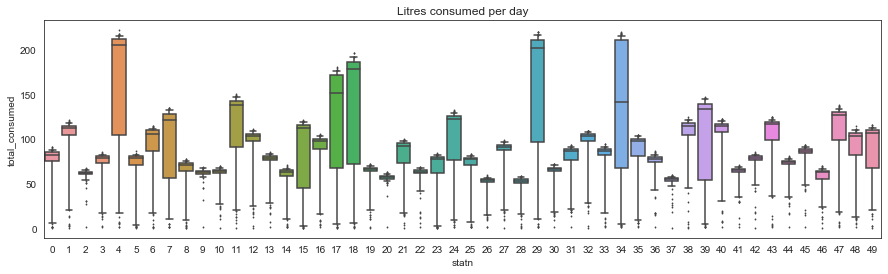

In [11]:
# Boxplot because violin not clear in small plot or will take make space for 50 stations
plt.figure(figsize=(15, 4))
fig=sns.boxplot(x='statn',y='total_consumed',data=L_day,whis=[5, 95],fliersize=1)
plt.title('Litres consumed per day');

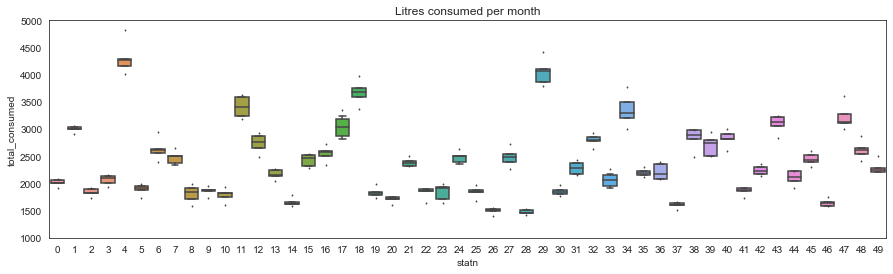

In [12]:
#Monthly consumption at differemt stations
L_month=combined.groupby(['statn','month']).amount_vended_L.sum().reset_index(name ='total_consumed')
plt.figure(figsize=(15, 4))
fig=sns.boxplot(x='statn',y='total_consumed',data=L_month,whis=[5, 95],fliersize=1)
plt.title('Litres consumed per month');
fig.set_ylim([1000,5000]);

Note, boxplots by default show whiskers at Q1-1.5*IQR and Q3+1.5*IQR. I have changed them to 5 and 95 percentile (1.65 std devs) to show the range in which 90% of the data lies, which is more intuitive to me than whiskers based on IQR.

Monthly consumption averages between 2000 and 4500 L for the different stations. Monthly consumption seem to have less variation than daily for individual stations, which makes sense because short term daily variations are averaged over the month.

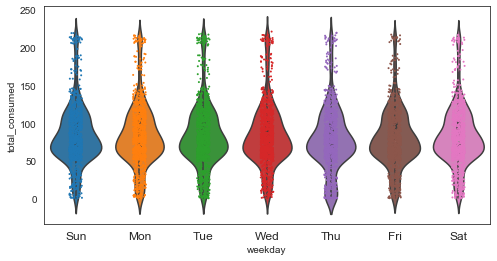

In [13]:
# Fairly even throughout the week #Can look at this for indvidual stations.
plt.figure(figsize=[8,4])
L_day['weekday']=[dt.datetime.weekday(i) for i in L_day.date]
sns.violinplot(x='weekday',y='total_consumed',data=L_day,whis=[5, 95],fliersize=1)
sns.stripplot(x='weekday',y='total_consumed',data=L_day,size=2)
plt.xticks(L_day.weekday.unique(),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=12);

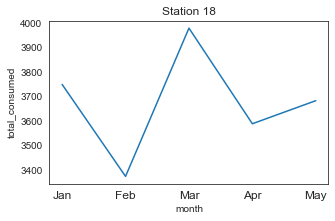

In [14]:
plt.figure(figsize=[5,3])
L_month=L_month[L_month.month!=6] #Dropping the single June 1st datapoint
#sns.boxplot(x='month',y='total_consumed',data=L_month,whis=[5, 95],fliersize=1)
stn=18 #random.randrange(50)
L_m_stn=L_month[L_month.statn==stn]
sns.lineplot(x='month',y='total_consumed',data=L_m_stn)
plt.xticks(L_m_stn.month.unique(),['Jan','Feb','Mar','Apr','May'],fontsize=12);
plt.title('Station '+str(stn));

No difference in consumption on weekends (Sat/Sun, or Fri/Sat for countries that might observe Friday as a holiday)
We also don'y see any seasonality overall, but the countries could be north as well as south of the equator. Hence, I plotted monthly consumption for few stations individually, but also didn't see a seasonal pattern there. 

## Operations
Lets look at consumable components:
- time between them emptying and refilling
- are they refilled only after emptying, or when the level is low
- is the order placed ahead, when level is low, or do the franchises place orders only after water tank/flavors are emptied
- do we see any indications of CO2 dispenser, since we don't have any data for that?
- how their levels affect consumption over time!

### Downtime

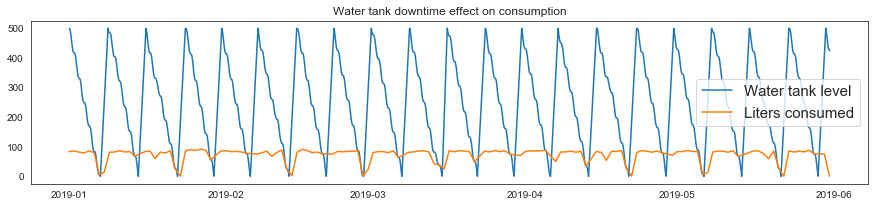

In [36]:
# How does water level downtime affect consumption? 
# Water is the ubiquitous component in all drinks, so might be the most important!
stn= 0 #input any number 0-49

plt.figure(figsize=[15,3])
df_stn=combined[combined['statn']==stn]
plt.plot_date(df_stn.timestamp,df_stn.tank_level_after,fmt='-')
plt.plot_date(L_day.loc[L_day['statn'] == stn, 'date'],L_day.loc[L_day['statn'] == stn, 'total_consumed'],'-')
plt.legend(['Water tank level','Liters consumed'],fontsize=15)
plt.title('Water tank downtime effect on consumption');

We don't see any clear other variable for downtime, such as loss of power & drainage of solar powered battery.
We can explore CO2 and flavors later, but water tank emptying seems the predominant reason for drop in consumption.

In [16]:
# No CO2 data, trying to find seltzer downtime due to CO2 finishing
# Come back to this later
# df.loc[df['flavor_id'] > 0, 'flavor_id'] = 1
# plt.figure(figsize=[15,3])
# plt.plot_date(df['timestamp'][300:800],df['flavor_id'][300:800],fmt='-')


In [17]:
#Create a dataframe with time taken to refill water (this includes pre-emptive fills, so not all are downtime)

refill_water=pd.DataFrame(columns=['tank_level_before_refill','refilled_time','time_to_refill','statn'])
for i in range(len(combined)-1):
    if combined.tank_level_after[i]<combined.tank_level_after[i+1] and combined.statn[i]==combined.statn[i+1]:
        refill_water.loc[len(refill_water)]=[combined.tank_level_after[i],combined.timestamp[i+1],combined.timestamp[i+1]-combined.timestamp[i],combined.statn[i]]

#print(len(refill_water))
refill_water.head()  

refill_water['time_h']=refill_water.time_to_refill.dt.total_seconds()/3600
water_refill_time=refill_water.groupby('statn').time_h.mean().reset_index(name='avg_hours_to_refill_water')
water_refill_time.head()

,statn,avg_hours_to_refill_water
0,0,35.989167
1,1,22.606667
2,2,0.305556
3,3,18.923077
4,4,39.717460


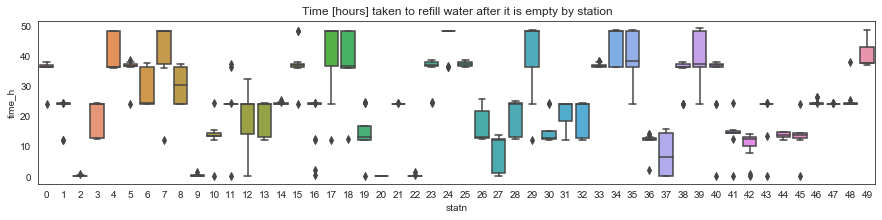

In [18]:
plt.figure(figsize=[15,3]) #To do: remove premptive fills
sns.boxplot(x='statn',y='time_h',data=refill_water)
plt.title('Time [hours] taken to refill water after it is empty by station');

In [19]:
#Some stations replaced water tanks before they were over
watr_rep_b4_over=refill_water.loc[refill_water.tank_level_before_refill>0.5,['tank_level_before_refill','statn']]
watr_rep_b4_over.head()

,tank_level_before_refill,statn
35,19.5,2
36,18.0,2
37,31.0,2
38,20.0,2
39,18.5,2


Some stations refill their water tanks within less than an hour of emptying, on an average. Others take up to 2 days. The ones that take longer to refill water might be able to address downtime by requesting a delivery early! Lets see next, how much time it takes between placing an order for a water tank, and getting the delivery.

### Orders and delivery time

In [20]:
# Compare order time to level (to find time betn order & delivery ...
# and recommend something like place order when level is down to 5)

orders=pd.read_csv('data/orders.csv')
orders.timestamp=pd.to_datetime(orders.timestamp)
orders['timestamp'] = orders.timestamp.dt.round(freq='min')
orders.head()

,product_ordered,station,timestamp
0,water,0,2019-01-06 07:33:00
1,water,0,2019-01-13 20:41:00
2,peach,0,2019-01-16 17:35:00
3,pine_needle,0,2019-01-16 17:46:00
4,acai,0,2019-01-16 17:57:00


In [21]:
water_orders=orders.loc[orders.product_ordered=='water']
water_orders=water_orders.reset_index(drop=True)
pct=round(len(water_orders)/len(orders)*100,1)
print(f'{pct}% of orders were water')

40.6% of orders were water


In [22]:
delivery_time=pd.DataFrame(columns=['delivery_time','statn'])
j=0
for i in range(len(water_orders)):
    if water_orders.station[i]==refill_water.statn[j]:
        delivery_time.loc[len(delivery_time)]=[refill_water.refilled_time[j]-water_orders.timestamp[i],water_orders.station[i]]
        j=j+1
        
delivery_time.head()

,delivery_time,statn
0,2 days 09:56:00,0
1,2 days 08:24:00,0
2,2 days 11:14:00,0
3,2 days 10:31:00,0
4,2 days 01:35:00,0


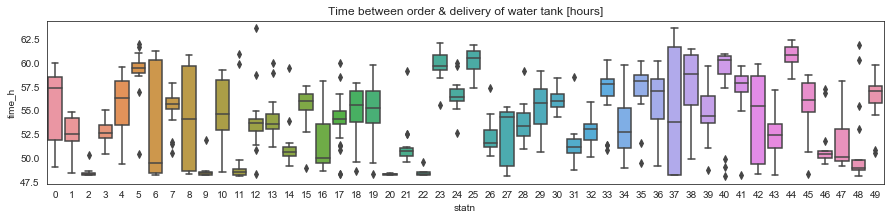

In [23]:
delivery_time['time_h']=delivery_time.delivery_time.dt.total_seconds()/3600
plt.figure(figsize=[15,3])
sns.boxplot(x='statn',y='time_h',data=delivery_time)
plt.title('Time between order & delivery of water tank [hours]');

Delivery time for a water tank is consistently between 2-3 days. So we can later look into demand projection and make orders in time to avoid downtime!
There's more analysis we can do, ask about CO2 data, give recommended level at which stations should already place the next order by projecting consumption, etc. But moving on to flavor modeling in interest of time. 

In [32]:
#Export combined data for use in flavor analysis
#We might not need some columns, and can derive them if we do. So dropping them.
combined.drop(columns=['month','weekday','hour','date','flavor_id'],inplace=True)
combined.to_csv('data/combined_data.csv',index=False)